In [5]:
# Import package
from nltk import word_tokenize as tokenize
import pandas as pd, csv
import operator
import os,random,math
import numpy as np

In [6]:
# Import file directory
path = "D:\Study\自然语言工程\高级\week2\lab2resources\lab2resources\sentence-completion\Holmes_Training_Data"

In [7]:
filenames = os.listdir(path)
n = len(filenames)
random.shuffle(filenames) # Randomly shuffle file names
trainingfiles = filenames[:int(n*0.5)] # Randomly select the name of training set file
heldoutfiles = filenames[int(n*0.5):] # Then grab the test set file name

In [8]:
class lanugage_model:
    
    def __init__(self,path,filesize,method):
        self.words = [] # An empty list of words used to store word tokens
        self.unigram = {} # An empty dictionary for storing unigram words
        self.bigram = {}
        self.trigram = {}
        self.quadrigram = {}
        
        self.gram = {} # The final gram is consistent with the method
        
        self.path = path # Get road strength
        self.filesize = filesize # Get file batch size
        self.method = method # Selection method
        
        self.get_words()
        self._processfiles()
        self._make_unknowns()
        self._discount()
        self._convert_to_probs()
        
    def get_words(self):
        # Get the word token, and add "_start" and "_end" 
        # to mark the beginning and end of each sentence
        for file in trainingfiles[:self.filesize]:
            print(f"processing {file}.text ")
            try:
                with open(os.path.join(path,file)) as instream:
                    for line in instream:
                        line = line.rstrip()
                        if len(line)>0:             
                            tokens = tokens=["__START"]+tokenize(line)+["__END"]
                            self.words.append(tokens)
            except UnicodeDecodeError:
                print("UnicodeDecodeError processing {}: ignoring rest of file".format(file))
                        
    
    def _processfiles(self):
    
        for i in self.words: # Get unigram model words and word count
            for j in i:
                self.unigram[j] = 0

        for i in self.words:
            for j in i:
                self.unigram[j] += 1

        if self.method == "bigram": # Get bigram model words and the number of words after each word
            for i in self.words:
                for j in range(len(i)-1):
                    self.bigram[i[j]] = {}
            for i in self.words:
                for j in range(len(i)-1):
                    self.bigram[i[j]][i[j+1]] = 0
            for i in self.words:
                for j in range(len(i)-1):
                    self.bigram[i[j]][i[j+1]] += 1
                    
            self.gram = self.bigram # Finally, self The gram dictionary will store the same gram element as method.
                    
        if self.method == "trigram": # Get trigram model words and the number of words after each word
            for i in self.words:
                for j in range(len(i)-2):
                    self.trigram[i[j]] = {}
            for i in self.words:
                for j in range(len(i)-2):
                    self.trigram[i[j]][i[j+1],i[j+2]] = 0
            for i in self.words:        
                 for j in range(len(i)-2):
                    self.trigram[i[j]][i[j+1],i[j+2]] += 1
                    
            self.gram = self.trigram
                    
        if self.method == "quadrigram": # Get the word of the quadrigram model and the number of words after each word
            for i in self.words:
                for j in range(len(i)-3):
                    self.quadrigram[i[j]] = {}
            for i in self.words:
                for j in range(len(i)-3):
                    self.quadrigram[i[j]][i[j+1],i[j+2],i[j+3]] = 0
            for i in self.words:        
                 for j in range(len(i)-3):
                    self.quadrigram[i[j]][i[j+1],i[j+2],i[j+3]] += 1
                    
            self.gram = self.quadrigram
            
            
    def _convert_to_probs(self): # term frequency 
        self.unigram = {k:v/sum(self.unigram.values()) for (k,v) in self.unigram.items()} 
        
        # Calculate the word frequency of packaged bigram or trigram or quadrigram, and return to gram dictionary
        self.gram = {key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.gram.items()}
    
    def get_prob(self,token,context=""):
        # Be computed_ prob_ Line function call, which is used to count the probability of obtaining words and calculate perflexity
        
        if self.method == "unigram":
            return self.unigram.get(token,self.unigram.get("__UNK",0))
        else:
            gram = self.gram.get(context[-1],self.gram.get("__UNK",{})) # Probability of getting "__unk" token
            big_p = gram.get(token,gram.get("__UNK",0)) 
            
            lmbda = gram["__DISCOUNT"] # Get "_discount" token probability
            
            uni_p = self.unigram.get(token,self.unigram.get("__UNK",0))
            #print(big_p,lmbda,uni_p)
            p = big_p + lmbda * uni_p            
            return p          
        
    def nextlikely(self,current=""):  # Screen the words most likely to form a sentence
        blacklist=["__START","__DISCOUNT"]
       
        if self.method == "unigram":
            dist = self.unigram
        else:
            dist = self.gram.get(current,{})
    
        mostlikely=list(dist.items())
        # filter out any undesirable tokens
        filtered=[(w,p) for (w,p) in mostlikely if w not in blacklist]
        print(current,len(filtered))
        # choose one randomly from the top k
        words,probdist = zip(*filtered)
        res = random.choices(words,probdist)[0]
        return res
    
    def generate(self,end="__END",limit=20): # Generate a possible sentence
        current="__START"
        tokens=[]
        while  current != end and len(tokens) < limit:
            current=self.nextlikely(current=current)
            tokens.append(current)
        return " ".join(tokens[:-1])
    
    def compute_prob_line(self,line): 
       # Be computed_ The probability function call is used to calculate the probability
        tokens=["__START"]+tokenize(line)+["__END"]
        acc=0
        for i,token in enumerate(tokens[1:]):
            acc += np.log(self.get_prob(token,tokens[:i+1]))
        return acc,len(tokens[1:])
    
    def compute_probability(self):
        # computes the probability (and length) of a corpus contained in filenames
        # Select the test set file name to calculate the property
        total_p=0
        total_N=0
        for i,afile in enumerate(heldoutfiles[:self.filesize]):
            print("Processing file {}:{}".format(i,afile))
            try:
                with open(os.path.join(path,afile)) as instream:
                    for line in instream:
                        line=line.rstrip()
                        if len(line)>0:
                            p,N = self.compute_prob_line(line)
                            total_p += p
                            total_N += N
            except UnicodeDecodeError:
                print("UnicodeDecodeError processing file {}: ignoring rest of file".format(afile))
        return total_p,total_N
    
    def compute_perplexity(self):
        
        #compute the probability and length of the corpus
        #calculate perplexity
        #lower perplexity means that the model better explains the data
        
        p,N = self.compute_probability()
        #print(p,N)
        pp = np.exp(-p/N)
        return pp  
    
    def _make_unknowns(self,known=2): # Add unknown word token "_unk"
        unknown = 0
        if self.method == "unigram"or self.method == "bigram":
            for (k,v) in list(self.unigram.items()):
                if v < known: # If less than, the word is deleted from the dictionary and replaced with a "_unk" token
                    del self.unigram[k]
                    self.unigram["__UNK"] = self.unigram.get("__UNK",0) + v
            for (k,adict) in list(self.gram.items()):
                for (kk,v) in list(adict.items()):
                    isknown = self.unigram.get(kk,0)
                    if isknown == 0: # If equal to 0, the word is removed from the dictionary and replaced with a "_unk" token
                        adict["__UNK"] = adict.get("__UNK",0) + v
                        del adict[kk]
                isknown = self.unigram.get(k,0)
                if isknown == 0:
                    del self.gram[k]
                    current = self.gram.get("__UNK",{})
                    current.update(adict)
                    self.gram["__UNK"] = current

                else:
                    self.gram[k] = adict
                    
        if self.method == "trigram"or self.method == "quadrigram":
            for (k,v) in list(self.unigram.items()):
                if v < known:
                    del self.unigram[k]
                    self.unigram["__UNK"] = self.unigram.get("__UNK",0) + v
                    
            #Trigram and quadrigram contain a word pair tuple, which needs to add a layer of loop
            for (k,adict) in list(self.gram.items()): 
                for (kk,v) in list(adict.items()):
                    for vv in kk: 
                        isknown = self.unigram.get(vv,0)
                        dels = False
                        if isknown == 0:
                            adict["__UNK"] = adict.get("__UNK",0) + v
                            dels = True
                    if dels == True:
                        del adict[kk]
                isknown = self.unigram.get(k,0)
                if isknown == 0:
                    del self.gram[k]
                    current = self.gram.get("__UNK",{})
                    current.update(adict)
                    self.gram["__UNK"] = current
                    
                else:
                    self.gram[k] = adict
        
    def _discount(self,discount=0.75):
        #discount each bigram count by a small fixed amount
        self.gram={k:{kk:value-discount for (kk,value) in adict.items()}for (k,adict) in self.gram.items()}
        
        #for each word, store the total amount of the discount so that the total is the same 
        #i.e., so we are reserving this as probability mass
        for k in self.gram.keys():
            lamb = len(self.gram[k])
            self.gram[k]["__DISCOUNT"] = lamb * discount

In [9]:
# Drawing
import matplotlib.pyplot as plt
import numpy as np

methods = ["unigram","bigram","trigram","quadrigram"]

unigram = []
bigram = []
trigram = []
quadrigram = []

a = np.arange(1,6)

for method in methods:
    for file in range(1,6):
            mylm = lanugage_model(path,file,method)
            perplexity = mylm.compute_perplexity()
            eval(method).append(perplexity)

processing MASAC10.TXT.text 
Processing file 0:WALDN10.TXT
processing MASAC10.TXT.text 
processing MARKT10.TXT.text 
Processing file 0:WALDN10.TXT
Processing file 1:POLST10.TXT
processing MASAC10.TXT.text 
processing MARKT10.TXT.text 
processing JBALL10.TXT.text 
Processing file 0:WALDN10.TXT
Processing file 1:POLST10.TXT
Processing file 2:TPSPD10.TXT
processing MASAC10.TXT.text 
processing MARKT10.TXT.text 
processing JBALL10.TXT.text 
processing 11WOZ10.TXT.text 
Processing file 0:WALDN10.TXT
Processing file 1:POLST10.TXT
Processing file 2:TPSPD10.TXT
Processing file 3:TLFNS10.TXT
processing MASAC10.TXT.text 
processing MARKT10.TXT.text 
processing JBALL10.TXT.text 
processing 11WOZ10.TXT.text 
processing AGNSG10.TXT.text 
Processing file 0:WALDN10.TXT
Processing file 1:POLST10.TXT
Processing file 2:TPSPD10.TXT
Processing file 3:TLFNS10.TXT
Processing file 4:HHOTL10.TXT
processing MASAC10.TXT.text 
Processing file 0:WALDN10.TXT
processing MASAC10.TXT.text 
processing MARKT10.TXT.text

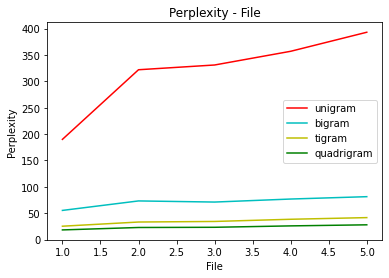

In [10]:
fig = plt.figure(1)
ax = plt.subplot(111)
ax.plot(a, unigram, 'r',label='unigram')
ax.plot(a, bigram, 'c',label='bigram')
ax.plot(a, trigram,'y',label='tigram')
ax.plot(a, quadrigram,'g',label='quadrigram')
ax.legend()
plt.xlabel('File')
plt.ylabel('Perplexity')
plt.title('Perplexity - File')
plt.show()

In [46]:
left_unigram_score,left_bigram_score,left_trigram_score,left_quadrigram_score = [],[],[],[]
left_right_unigram_score,left_right_bigram_score,left_right_trigram_score,left_right_quadrigram_score = [],[],[],[]

with open("N-gram.txt", "r") as f:  
    data = f.readlines() 
    for i in data:
        if "left unigram score"in i:
            num = float('0.'+ ''.join([x for x in i if x.isdigit()]))*10
            left_unigram_score.append(num)
            
        if "left bigram score:"in i:
            num = float('0.'+ ''.join([x for x in i if x.isdigit()]))*10
            left_bigram_score.append(num)
            
        if "left trigram score:"in i:
            num = float('0.'+ ''.join([x for x in i if x.isdigit()]))*10
            left_trigram_score.append(num)
        
        if "left quadrigram score"in i:
            num = float('0.'+ ''.join([x for x in i if x.isdigit()]))*10
            left_quadrigram_score.append(num)
            
        if "left&right unigram score"in i:
            num = float('0.'+ ''.join([x for x in i if x.isdigit()]))*10
            left_right_unigram_score.append(num)
            
        if "left&right bigram score"in i:
            num = float('0.'+ ''.join([x for x in i if x.isdigit()]))*10
            left_right_bigram_score.append(num)
            
        if "left&right trigram score"in i:
            num = float('0.'+ ''.join([x for x in i if x.isdigit()]))*10
            left_right_trigram_score.append(num)
            
        if "left&right quadrigram score"in i:
            num = float('0.'+ ''.join([x for x in i if x.isdigit()]))*10
            left_right_quadrigram_score.append(num)

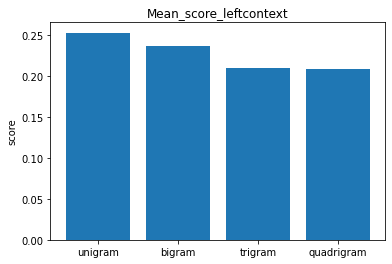

In [76]:
data = [sum(left_unigram_score)/5, sum(left_bigram_score)/5, sum(left_trigram_score)/5, sum(left_quadrigram_score)/5]
labels = ['unigram', 'bigram', 'trigram', 'quadrigram']
 
plt.bar(range(len(data)), data, tick_label=labels)
plt.ylabel('score')
plt.title('Mean_score_leftcontext')
plt.show()

In [75]:
data

[0.2530769230769231,
 0.23692307692307696,
 0.2103846153846154,
 0.2092307692307692]

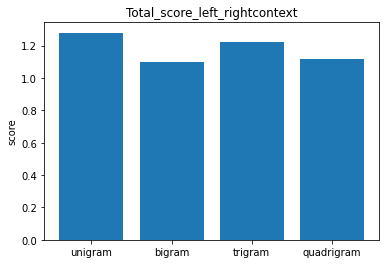

In [49]:
data = [sum(left_right_unigram_score), sum(left_right_bigram_score), sum(left_right_trigram_score), sum(left_right_quadrigram_score)]
labels = ['unigram', 'bigram', 'trigram', 'quadrigram']
 
plt.bar(range(len(data)), data, tick_label=labels)
plt.ylabel('score')
plt.title('Total_score_left_rightcontext')
plt.show()

In [42]:
with open("N-gram.txt", "r") as f:  
    data = f.readlines() 
    for i in data:
        if "left unigram score"in i:
            num = float('0.'+ ''.join([x for x in i if x.isdigit()]))*10
            print(num)
            
        if "left bigram score:"in i:
            num = int(''.join([x for x in i if x.isdigit()]))
            print(num)
            
        if "left trigram score:"in i:
            num = int(''.join([x for x in i if x.isdigit()]))
            
        
        if "left quadrigram score"in i:
            num = int(''.join([x for x in i if x.isdigit()]))
            

0.25288461538461543
0.2567307692307692
0.2625
0.25384615384615383
0.23942307692307693
24615384615384617
23942307692307693
24134615384615385
23942307692307693
21826923076923077


In [ ]:
data_left = [sum(left_unigram_score), sum(left_bigram_score), sum(left_trigram_score), sum(left_quadrigram_score)]
data_left_right = [sum(left_right_unigram_score), sum(left_right_bigram_score), sum(left_right_trigram_score), sum(left_right_quadrigram_score)]
labels = ['unigram', 'bigram', 'trigram', 'quadrigram']

plt.bar(range(len(data_left)), data_left, tick_label=labels)
plt.ylabel('score')
plt.title('Total_score_left_rightcontext')
plt.show()

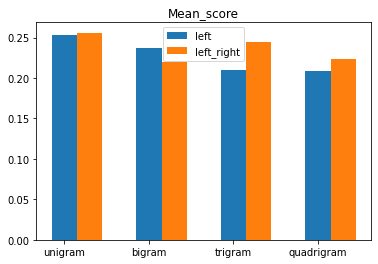

In [78]:
data_left = [sum(left_unigram_score)/5, sum(left_bigram_score)/5, sum(left_trigram_score)/5, sum(left_quadrigram_score)/5]
data_left_right = [sum(left_right_unigram_score)/5, sum(left_right_bigram_score)/5, sum(left_right_trigram_score)/5, sum(left_right_quadrigram_score)/5]

size = 4
x = np.arange(size)
a = data_left
b = data_left_right
c = np.random.random(size)
labels = ['unigram', 'bigram', 'trigram', 'quadrigram']
 
total_width, n = 0.9, 3
width = total_width / n
x = x - (total_width - width) / 2
 
plt.bar(x, a,  width=width, tick_label=labels,label='left')
plt.bar(x + width, b, width=width, label='left_right')
plt.title('Mean_score')
plt.legend()
plt.show()

In [65]:
a

array([0.90738541, 0.61544739, 0.33925909, 0.58342356, 0.52920478])

In [79]:
data_left

[0.2530769230769231,
 0.23692307692307696,
 0.2103846153846154,
 0.2092307692307692]

In [80]:
data_left_right

[0.25596153846153846,
 0.21980769230769232,
 0.24480769230769234,
 0.2230769230769231]

In [84]:
gram = sorted(mylm.unigram.items(),key=lambda x:x[1],reverse = True)

In [88]:
data = gram[:10]
word = []
probs = []

In [89]:
for i in data:
    word.append(i[0])
    probs.append(i[1])

C:\Users\18031\AppData\Local\Temp/ipykernel_72564/3656957424.py:1: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.barh(range(len(probs)), probs,tick_label=word,color='cmb')


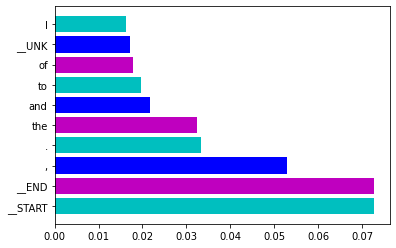

In [100]:
plt.barh(range(len(probs)), probs,tick_label=word,color='cmb')
plt.show()

In [106]:
wiki_bigram,wiki_trigram = [],[]
google_bigram,google_trigram = [],[]
with open("Wordvec.txt", "r") as f:  
    data = f.readlines() 
    for i in data:
        if "WikiNews-vectors bigram score:"in i:
            num = float('0.'+ ''.join([x for x in i if x.isdigit()]))*10
            wiki_bigram.append(num)
            
        if "WikiNews-vectors trigram score:"in i:
            num = float('0.'+ ''.join([x for x in i if x.isdigit()]))*10
            wiki_trigram.append(num)
            
        if "GoogleNews-vectors bigram score:"in i:
            num = float('0.'+ ''.join([x for x in i if x.isdigit()]))*10
            google_bigram.append(num)
        
        if "GoogleNews-vectors trigram score:"in i:
            num = float('0.'+ ''.join([x for x in i if x.isdigit()]))*10
            google_trigram.append(num)

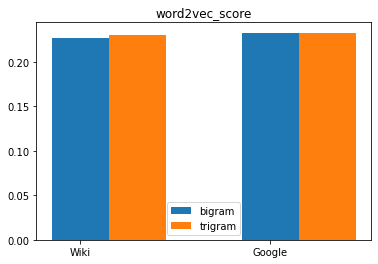

In [108]:
wiki = [sum(wiki_bigram)/5, sum(wiki_trigram)/5]
google = [sum(google_bigram)/5, sum(google_trigram)/5]

size = 2
x = np.arange(size)
a = wiki
b = google
c = np.random.random(size)
labels = ['Wiki', 'Google']
 
total_width, n = 0.9, 3
width = total_width / n
x = x - (total_width - width) / 2
 
plt.bar(x, a,  width=width, tick_label=labels,label='bigram')
plt.bar(x + width, b, width=width, label='trigram')
plt.title('word2vec_score')
plt.legend()
plt.show()

[0.2273076923076923, 0.2328846153846154]

[0.2303846153846154, 0.2325]